In [178]:
import math
import random
import matplotlib.pyplot as plt
import numpy as np
import timeit

## Auxillary Functions

**getCrossProduct(p0, p1, p2)**

Description: Used to determine whether p1 or p2 is more counterclockwise relative to p0. Returns -1 (p1 more counterclockwise) 0 (points are collinear), 1 (p2 more counterclockwise). 

Parameters:
- p0, p1, p2 : Points that store the x, y-coordinate in tuple form (x,y)

**findFurthest(origin, points)**

Description: Used to find the point in the given list (points) that is furthest away from the origin and returns it. 

Parameters:
- origin : (x, y) point in tuple form
- points : List of (x, y) points in tuple form

**binarySearch(subHull, curPoint)**

Description: Used for Chan's algorithm to find and return the rightmost point in a given sub-hull with respect to the current point (curPoint).

Parameters:
- subHull : List of points that lie on the sub-hull
- curPoint : (x, y) point in tuple form 

In [179]:
def getCrossProduct(p0,p1,p2):
    """
        Given 3 points, it returns the cross-product
        The cross-product lets us know whether the three points are collinear or whether 1 point is more (counter)clockwise from the other point
    """
    cross_product = (p1[0] - p0[0]) * (p2[1]-p0[1]) - (p2[0]-p0[0]) * (p1[1]-p0[1])

    if cross_product == 0:
        return 0 #p1
    elif cross_product > 0:
        return 1 #p2
    else:
        return -1 #p1

In [180]:
def findFurthest(origin, points):
    """
        Finds the squared distance between points in the "points" list relative to the origin. 
        Returns the point which is furthest away from the origin
    """
    def distance(point):
        return math.sqrt((origin[0] - point[0]) ** 2 + (origin[1] - point[1]) ** 2)
    
    return max(points, key=distance, default=None)

In [181]:
def binarySearch(subHull, curPoint):

    hullSize = len(subHull)

    if hullSize == 1:
        return subHull[0]
    elif hullSize == 2:
        crossProduct = getCrossProduct(curPoint, subHull[0], subHull[1])
        if crossProduct > 0:
            return subHull[0]
        elif crossProduct < 0:
            return subHull[1]
        else:
            if curPoint == subHull[0]:
                return subHull[1]
            elif curPoint == subHull[1]:
                return subHull[0]
            return findFurthest(curPoint, [subHull[0], subHull[1]])

    pointer = 0
    # stepSize = max(hullSize >> 1, 1)
    stepSize = hullSize >> 1
    if stepSize == 0:
        stepSize = 1

    while True:
        pointerChanged = False
        # stepSize = max(stepSize >> 1, 1)
        if stepSize != 1:
            stepSize >>= 1

        for operation in [+1, -1]:
            nextPointer = (pointer + operation) % hullSize

            cp = getCrossProduct(curPoint, subHull[pointer], subHull[nextPointer])
            if cp < 0:
                pointer = (pointer + (stepSize * operation)) % hullSize
                pointerChanged = True
                break
            elif cp == 0:
                if curPoint == subHull[nextPointer]:
                    oppositePointer = (nextPointer + (operation)) % hullSize
                    cp = getCrossProduct(curPoint, subHull[pointer], subHull[oppositePointer])
                    if cp < 0:
                        return subHull[oppositePointer]
                    else:
                        return subHull[pointer]
                else:
                    nextNextPointer = (nextPointer + operation) % hullSize
                    if (getCrossProduct(curPoint, subHull[nextPointer], subHull[nextNextPointer])> 0):
                        return findFurthest(curPoint, [subHull[pointer], subHull[nextPointer]])

        if not pointerChanged:
            return subHull[pointer]


In [182]:
def jarvis(inputSet):
    outputSet = []
    if len(inputSet) < 3: # Since anything less than these number of points can't create a convex hull
        return inputSet

    # Find the leftmost point
    firstPoint = min(inputSet, key=lambda p: (p[0], p[1]))
    curPoint = firstPoint
    nextPoint = None

    while nextPoint != firstPoint:
        outputSet.append(curPoint)
        nextPoint = inputSet[0] if inputSet[0] != curPoint else inputSet[1]

        # Iterate through all points in the inputSet to find the rightmost point relative to the current point
        for testPoint in inputSet:

            if testPoint == curPoint:
                continue
            crossProduct = getCrossProduct(curPoint, nextPoint, testPoint)

            if crossProduct > 0: # If the point being tested if more anticlockwise relative to the current point
                nextPoint = testPoint

            elif crossProduct == 0: # If all 3 points are collinear
                nextPoint = findFurthest(curPoint, [nextPoint, testPoint])
            
        curPoint = nextPoint
    return outputSet

In [183]:
def grahamScan(inputSet):
    
    pointAnglesDict = {} # Stores points in a list according to their angles - Points with the same angle will be appended to the list
    firstPoint = min(inputSet, key=lambda p: (p[1], p[0])) # Get the lowest and leftmost point
    outputSet = [firstPoint]

    # Calculate the polar angle for each point in the inputSet
    for point in inputSet:
        if point == firstPoint:
            continue
        
        angle_rad = math.atan2(point[1] - firstPoint[1], point[0] - firstPoint[0] )

        if angle_rad in pointAnglesDict:
            pointAnglesDict[angle_rad].append(point)
        else:
            pointAnglesDict[angle_rad] = [point]

    # Sort the points by their angles
    sortedPointAngles = sorted(list(pointAnglesDict.items()))

    point = None
    
    for pointDict in sortedPointAngles: # Iterate through all the points in order of their polar angle
        # Checks whether there are more than one point with the same angle. If there is, the furthest is taken
        if len(pointDict[1]) > 1:
            point = findFurthest(firstPoint, pointDict[1])
        else:
            point = pointDict[1][0]

        # Removes points before the newest point to be added until it a convex is formed. Any points between that causes a concave will be removed
        while len(outputSet) >= 2 and getCrossProduct(outputSet[-2], outputSet[-1], point) <= 0:
            outputSet.pop()  # Remove the last point in the outputSet because it makes a non-left turn
        outputSet.append(point)

    return outputSet

Following are the "dynamic" Chan's algorithm. This is what was mentioned in his paper. The group size (m) is found dynamically - meaning that if m is not greater than or equal to the number of hull points (h), then the m is doubled. The final hull points are returned when m >= h

In [184]:
def dynamicBinaryChan(inputSet):
    hullSize = len(inputSet)
    
    firstPoint = min(inputSet, key=lambda p: (p[0], p[1]))
    
    for i in range(hullSize):
        outputSet = []
        groupSize = 2**2**i

        subsets = [inputSet[i : i + groupSize] for i in range(0, hullSize, groupSize)]
        subHulls = [grahamScan(subset) for subset in subsets]

        
        curPoint = firstPoint
        nextPoint = None

        for _ in range(groupSize):
            outputSet.append(curPoint)
            rightPoints = [binarySearch(subHull, curPoint) for subHull in subHulls]
            nextPoint = rightPoints[0] if rightPoints[0] != curPoint else rightPoints[1]

            for rightPoint in rightPoints:
                if rightPoint == curPoint:
                    continue

                crossProduct = getCrossProduct(curPoint, nextPoint, rightPoint)
                if crossProduct < 0:
                    nextPoint = rightPoint
                elif crossProduct == 0:
                    nextPoint = findFurthest(curPoint, [nextPoint,rightPoint])

            curPoint = nextPoint
            if nextPoint == firstPoint:
                return outputSet
            

In [185]:
def dynamicLinearChan(inputSet):
    hullSize = len(inputSet)
    
    firstPoint = min(inputSet, key=lambda p: (p[0], p[1]))
    
    for i in range(hullSize):
        outputSet = []
        groupSize = 2**2**i

        subsets = [inputSet[i : i + groupSize] for i in range(0, hullSize, groupSize)]
        subHulls = [grahamScan(subset) for subset in subsets]
        allSubHullPoints = [point for subHull in subHulls for point in subHull]

        
        curPoint = firstPoint
        nextPoint = None

        for _ in range(groupSize):
            outputSet.append(curPoint)

            nextPoint = allSubHullPoints[0] if allSubHullPoints[0] != curPoint else allSubHullPoints[1]

            for testPoint in allSubHullPoints:
                if testPoint == curPoint:
                    continue
                crossProduct = getCrossProduct(curPoint, nextPoint, testPoint)
                if crossProduct < 0:
                    nextPoint = testPoint
                elif crossProduct == 0:
                    nextPoint = findFurthest(curPoint, [nextPoint,testPoint])

            curPoint = nextPoint
            if nextPoint == firstPoint:
                return outputSet

Following are the "optimised" Chan's algorithm. We found that m=h did not give optimal results and hence why also implemented Chan's with a predicted optimal group size (m) given the size of the input set.

In [186]:
def optLinearChan(inputSet, groupSize):
  outputSet = []
  
  subPoints = [inputSet[i:i + groupSize] for i in range(0, len(inputSet), groupSize)]
  subHulls = [grahamScan(points) for points in subPoints]
  allSubHullPoints = [point for subHull in subHulls for point in subHull]

  outputSet = jarvis(allSubHullPoints)

  return outputSet


In [187]:
def optBinaryChan(inputSet, groupSize=-1):
    hullSize = len(inputSet)

    if groupSize == -1:
        groupSize = math.ceil(math.sqrt(hullSize))

    subsets = [inputSet[i : i + groupSize] for i in range(0, hullSize, groupSize)]
    outputSet = []
    subHulls = [grahamScan(subset) for subset in subsets]

    firstPoint = min(inputSet, key=lambda p: (p[1], p[0]))
    curPoint = firstPoint
    nextPoint = None
    
    while nextPoint != firstPoint:
        outputSet.append(curPoint)
        rightPoints = [binarySearch(subHull, curPoint) for subHull in subHulls]
        nextPoint = rightPoints[0] if rightPoints[0] != curPoint else rightPoints[1]

        for rightPoint in rightPoints:
            if rightPoint == curPoint:
                continue
            crossProduct = getCrossProduct(curPoint, nextPoint, rightPoint)
            if crossProduct < 0:
                nextPoint = rightPoint
            elif crossProduct == 0:
                nextPoint = findFurthest(curPoint, [nextPoint, rightPoint])

        curPoint = nextPoint
    return outputSet


In [188]:
def getGroupSize(inputSize):
    """
        These are the optimal group size values that were found through experimentation.
    """

    if inputSize >= 100000:
        return 2000
    elif inputSize >= 10000:
        return math.ceil(0.13 * inputSize + 728)
    elif inputSize >= 5000:
        return math.ceil(inputSize / 7)
    elif inputSize >= 1000:
        return 700
    elif inputSize >= 500:
        return math.ceil(inputSize / 3)
    elif inputSize >= 100:
        return math.ceil(inputSize / 2)
    else:
        return math.ceil(inputSize / 3)
        

In [189]:
class TestDataGenerator(): #A class to represent a synthetic data generator.
    
    def __init__(self):
        self.points = [] # This is to store 1 test case
        self.dataSet = [] # This stores multiple test cases

    def generatePoints(self, size : int):
        self.points = []
        while len(self.points) < size:
            xp = random.randint(0,32767)
            yp = random.randint(0,32767)
            self.points.append((xp,yp))
        return self.points

    def generateHorizontalLine(self, size : int):
        self.points = []
        while len(self.points) < size:
            xp = random.randint(0,32767)
            self.points.append((xp,0))
        return self.points
    
    def genThirdPoint(self, pointA, pointB, theta, dist):
        # Calculating the angle of AB
        abAngle = math.atan2(pointB[1]-pointA[1], pointB[0]-pointA[0])
        # Adjust theta based on angle AB
        nextAngle = abAngle + theta
        # print("abAngle:", abAngle, "nextAngle:", nextAngle)

        cX = int(pointB[0] + dist * math.cos(nextAngle))
        cY = int(pointB[1] + dist * math.sin(nextAngle))

        return (cX, cY)

    def genPolygon(self, size : int):
        center = (16383, 16383)
        radius = 16000
        self.points = []
        
        # Estimating distance of each point
        dist = ((32767**2)/size)**0.5
        # dist = 2 * radius * math.sin(math.pi / size)
        print("Distance:", dist)
        theta = math.pi - (((size-2)*math.pi)/size)
        theta = 0.002
        print("Angle:", theta)

        if size % 2 == 0:
            point1X = 16383 - dist // 2
            point2X = 16383 + dist // 2
            self.points.append((point1X, 0))
            self.points.append((point2X, 0))
        else:
            self.points.append((16383, 0))
            self.points.append(self.genThirdPoint((0,0), self.points[0], theta, dist))

        while len(self.points) < size:
            self.points.append(self.genThirdPoint(self.points[-2], self.points[-1], theta, dist))


    def generateAllPointsOnHull(self, numPoints : int, center=(16383, 16383), radius=16000):
        self.points = []

        for i in range(numPoints):
            angle = 2 * math.pi * i / numPoints 
            x = int(center[0] + radius * math.cos(angle) )
            y = int(center[1] + radius * math.sin(angle) )
            self.points.append((x, y))

        random.shuffle(self.points)


    def fillHull(self, numTotalPoints : int, center=(16383,16383), radius = 16383): 
        while len(self.points) < numTotalPoints:
            angle = random.uniform(0, 2*math.pi)
            dist = random.uniform(0, radius-2000)

            x = int(center[0] + dist * math.cos(angle))
            y = int(center[1] + dist * math.sin(angle))
            self.points.append((x,y))


    def generatePointsGivenNincreasingH(self, numTotalPoints: int, numCases: int, minStartSize: int, center=(16383, 16383), radius=16383):

        self.dataSet = []
        hValues = []
        prevHullSize = minStartSize
        i = 3
        for _ in range(numCases):
            while True:
                self.generateAllPointsOnHull(2**i) 
                actualHull = grahamScan(self.points)
                actualHullSize = len(actualHull)
                if actualHullSize > numTotalPoints:
                    return hValues
                
                if actualHullSize > prevHullSize:
                    self.points = actualHull
                    # Filling the hull with rest of points
                    self.fillHull(numTotalPoints, center, radius)
                    hValues.append(actualHullSize)
                    self.dataSet.append(self.points)
                    prevHullSize = actualHullSize
                    i += 1
                    break
                else:
                    i += 1


        return hValues


    def generateAllHullDataset(self, minNumPoints : int, maxNumPoints : int, center=(16383, 16383), radius=16383):

        self.dataSet = []
        hValues = []
        prevHullSize = minNumPoints
        i = 3
        while True:
            self.generateAllPointsOnHull(2**i)
            actualHull = grahamScan(self.points)
            actualHullSize = len(actualHull)
            if actualHullSize > prevHullSize:
                self.dataSet.append(self.points)
                prevHullSize = actualHullSize
                hValues.append(actualHullSize)

            i += 1

            if actualHullSize >= maxNumPoints:
                break
        return hValues


    def generateDenseCluster(self, size: int):
       
        center = 16383
        mu = 0 #8150
        sigma = 5600 #5461
        self.points = []

        while len(self.points) < size:
            theta = random.uniform(0, 2 * math.pi)
            
            # Generate a magnitude r with normal distribution
            r = random.normalvariate(mu, sigma)
            x = math.ceil(r * math.cos(theta) + center)
            y = math.ceil(r * math.sin(theta) + center)
            # Convert polar to Cartesian coordinates
            x = max(min(x, 32767), 0)
            y = max(min(y, 32767), 0)
            
            self.points.append((x, y))



        return self.points

    

## TestDataGenerator
Attributes
----------

1. points - A list of tuples storing the (x,y) coordinate points of each point. Stores one test case.
2. dataSet - Stores multiple "points" lists. Stores multiple test cases. 

Methods
-------

**generatePoints(size)**
Description: Generates random points between 0 and 32767 in both the X and Y axis
Parameters:
- size : Total number of points that should be generated

**generateHorizontalLine(size)**
Description: Generates points along a line - All points are collinear
Parameters:
- size : Total number of points that should be generated

**generateAllPointsOnHull(numPoints, center, radius)**
Description: Generates 'numPoints' number of points evenly spaced along the circumference of a circle
Parameters:
- numPoints : Number of points that should be generated
- center (optional) : Optionally indicate tuple coordinate for center of the circle
- radius (optional) : Optionally indicate the radius of the circle

**fillHull(numTotalPoints, center, radius)**
Description: Generates points to fill the inside of a circle (which is generated from 'generateAllPointsOnHull')
Parameters:
- numTotalPoints : Number of points that should be generated in total. After generating the circle, this function will fill the rest of the points until the size is equal to totalPoints
- center (optional) : Optionally indicate tuple coordinate for center of the circle
- radius (optional) : Optionally indicate the radius of the circle

**generatePointsGivenNincreasingH(numTotalPoints, numCases, minStartSize, center, radius)**
Description: Parent function to 'generateAllPointsOnHull' and 'fillHull' to generate a data set with a specified total number of points and increasing hull points
Parameters:
- numTotalPoints : Total number of points that should be generated
- numCases : Indicates how many different values of hull points should be generated
- minStartSize : Indicates the minimum/starting value of hull points


In [190]:
import timeit
import matplotlib.pyplot as plt

class ExperimentalFramework():
    """
    A class to represent an experimental framework.

    """
    
    def __init__(self):
        self.testGen = TestDataGenerator()

        #Lists to store Convex Hull points generated from the respective algorithms
        self.jarvisBorder = []
        self.grahamBorder = []
        self.optLinearChanBorder = []
        self.optBinaryChanBorder = []
        self.dynLinearChanBorder = []
        self.dynBinaryChanBorder = []

        # Labels for graphs
        self.legendLabels = ["Jarvis", "Graham", "Chan (Linear, Optimised)", "Chan (Binary, Optimised)"]
        self.legendLabelsWithDynamic = ["Jarvis", "Graham", "Chan (Linear, Optimised)", "Chan (Binary, Optimised)", "Chan (Linear, Dynamic)", "Chan (Binary, Dynamic)"]
        

    # Run Algortiths and return Execution Times
        
    def runJarvis(self, points):
        start = timeit.default_timer()
        self.jarvisBorder = jarvis(points)
        end = timeit.default_timer()
        return (end - start)
    

    def runGraham(self, points):
        start = timeit.default_timer()
        self.grahamBorder = grahamScan(points)
        end = timeit.default_timer()
        return (end - start)


    def runOptBinaryChan(self, points, groupSize=-1):
        if groupSize == -1:
            groupSize = getGroupSize(len(points))
        
        start = timeit.default_timer()
        self.optBinaryChanBorder = optBinaryChan(points, groupSize)
        end = timeit.default_timer()
        return (end - start)
    

    def runOptLinearChan(self, points, groupSize=-1): 
        if groupSize == -1:
            groupSize = getGroupSize(len(points))
        
        start = timeit.default_timer()
        self.optLinearChanBorder = optLinearChan(points, groupSize)
        end = timeit.default_timer()
        return (end - start)
    

    def runDynBinaryChan(self, points):
        start = timeit.default_timer()
        self.dynBinaryChanBorder = dynamicBinaryChan(points)
        end = timeit.default_timer()
        return (end - start)
    

    def runDynLinearChan(self, points):
        start = timeit.default_timer()
        self.dynLinearChanBorder = dynamicLinearChan(points)
        end = timeit.default_timer()
        return (end - start)
    

    # Methods used to plot Graphs

    def drawHull(self, points, lines):
        margin = 50
        xPoints, yPoints = zip(*points)
        tempLines = lines + [lines[0]]
        xLine, yLine = zip(*tempLines)
        plt.scatter(xPoints, yPoints, color='red', s=3)
        plt.plot(xLine, yLine, '-', color='blue')

        plt.xlim(min(xPoints) - margin, max(xPoints) + margin)
        plt.ylim(min(yPoints) - margin, max(yPoints) + margin)
        plt.show()


    def plotPoints(self, points):
        margin = 5000
        xPoints, yPoints = zip(*points)
        plt.scatter(xPoints, yPoints, color='red', s=1)

        plt.xlim(min(xPoints) - margin, max(xPoints) + margin)
        plt.ylim(min(yPoints) - margin, max(yPoints) + margin)
        plt.show()


    def plotResults(self, xTitle, xValues, legendLabels, yTitle, yValueList, title="", vertLineCoord=None):
        plt.figure(figsize=(8,6))

        for i, yValues in enumerate(yValueList):
            plt.plot(xValues, yValues, 'o-', label=legendLabels[i])
        plt.title(title)
        plt.xlabel(xTitle)
        plt.ylabel(yTitle)
        plt.grid(True)

        if vertLineCoord is not None:
            plt.axvline(x=vertLineCoord, color = 'r')

        plt.legend()

        plt.tight_layout()
        plt.show()


    def stressTest(self, repeats, sizes):
        """
        This method performs a stress test on the implemented algorithms. It generates test cases of different sizes and
        runs each algorithm on these test cases for a specified number of repeats. 

        For each test case, it checks if all algorithms produce the same output (the convex hull points). If the outputs 
        are not the same, it increments a counter and stores the test case that caused the discrepancy. This helps in 
        identifying the test cases where the algorithms fail to provide the correct output.

        Parameters:
        repeats (int): The number of times each test case is repeated.
        sizes (list): A list of different sizes for the test cases.

        Returns:
        wrongCount (int): The number of test cases where the algorithms produced different outputs.
        wrongTests (list): A list of test cases where the algorithms produced different outputs.
        """
        wrongCount = 0
        wrongTests = []

        for size in sizes:
            print("\nCurrent Size:",size)
            for _ in range(repeats):
                
                self.testGen.generatePoints(size)
                
                self.runJarvis(self.testGen.points)
                self.runGraham(self.testGen.points)
                self.runOptLinearChan(self.testGen.points)
                self.runOptBinaryChan(self.testGen.points)
                self.runDynLinearChan(self.testGen.points)
                self.runDynBinaryChan(self.testGen.points)

                self.jarvisBorder.sort()
                self.grahamBorder.sort()
                self.optLinearChanBorder.sort()
                self.optBinaryChanBorder.sort()
                self.dynBinaryChanBorder.sort()
                self.dynLinearChanBorder.sort()

                if not (self.jarvisBorder == self.grahamBorder == self.optLinearChanBorder == self.optBinaryChanBorder == self.dynBinaryChanBorder == self.dynLinearChanBorder):
                    wrongTests.append(self.testGen.points)
                    wrongCount += 1

            print("Wrong So Far:", wrongCount)
        return wrongCount, wrongTests
    

    # C
    def compareAlgos(self, repeats, inputSizes, testType, withDynamicChan=False):
        """
        Compares All Algorithms for Random and Dense Clutter points and Plots a Graph of Input Size against Time Taken.

        Parameters:
            repeats (int): The number of times to repeat each test.
            inputSizes (list): A list of input sizes to test.
            testType (int): The type of test to perform. 0 for random points, 1 for dense cluster.
            withDynamicChan (bool, optional): Whether to include dynamic Chan's algorithm in the comparison. Defaults to False.

        Returns:
            None
        """
        # Test Type - 0 : Random, 1 : Dense Cluster
        titles =["Random", "Dense Cluster"]
        
        times = [[] for _ in range(6 if withDynamicChan else 4)]

        for inputSize in inputSizes:
            jarvisTimes = []
            grahamTimes = []
            optLinearChanTimes = []
            optBinaryChanTimes = []
            dynLinearChanTimes = []
            dynBinaryChanTimes = []
            for _ in range(repeats):
                if testType == 0:
                    self.testGen.generatePoints(inputSize)
                elif testType == 1:
                    self.testGen.generateDenseCluster(inputSize)

                jarvisTimes.append(self.runJarvis(self.testGen.points))
                grahamTimes.append(self.runGraham(self.testGen.points))
                optLinearChanTimes.append(self.runOptLinearChan(self.testGen.points))
                optBinaryChanTimes.append(self.runOptBinaryChan(self.testGen.points))
                if withDynamicChan:
                    dynLinearChanTimes.append(self.runDynLinearChan(self.testGen.points))
                    dynBinaryChanTimes.append(self.runDynBinaryChan(self.testGen.points))

            times[0].append(sorted(jarvisTimes)[repeats//2])
            times[1].append(sorted(grahamTimes)[repeats//2])
            times[2].append(sorted(optLinearChanTimes)[repeats//2])
            times[3].append(sorted(optBinaryChanTimes)[repeats//2])
            if withDynamicChan:
                times[4].append(sorted(dynLinearChanTimes)[repeats//2])
                times[5].append(sorted(dynBinaryChanTimes)[repeats//2])

        self.plotResults("Input Size", inputSizes, self.legendLabelsWithDynamic if withDynamicChan else self.legendLabels, "Time Taken", times, "Comparing Algorithms : " + titles[testType])


    
    def compareAlgosAllOnHull(self, repeats, minHullSize, maxHullSize, withDynamicChan=False):
        """
        Compares All Algorithms for the case where All points are on Hull and Plots a Graph of Input Size against Time Taken

        Parameters:
            repeats (int): The number of times to repeat each algorithm for accurate timing.
            minHullSize (int): The minimum number of points on the convex hull.
            maxHullSize (int): The maximum number of points on the convex hull.
            withDynamicChan (bool, optional): Whether to include dynamic Chan's algorithm in the comparison. Defaults to False.

        Returns:
            None
        """

        hValues = self.testGen.generateAllHullDataset(minHullSize, maxHullSize)
        jarvisTimes = []
        grahamTimes = []
        optLinearChanTimes = []
        optBinaryChanTimes = []

        times = [[] for _ in range(6 if withDynamicChan else 4)]

        for testCase in self.testGen.dataSet:
            jarvisTimes = []
            grahamTimes = []
            optLinearChanTimes = []
            optBinaryChanTimes = []
            dynLinearChanTimes = []
            dynBinaryChanTimes = []
            for _ in range(repeats):
                jarvisTimes.append(self.runJarvis(testCase))
                grahamTimes.append(self.runGraham(testCase))
                optLinearChanTimes.append(self.runOptLinearChan(testCase))
                optBinaryChanTimes.append(self.runOptBinaryChan(testCase))
                if withDynamicChan:
                    dynLinearChanTimes.append(self.runDynLinearChan(testCase))
                    dynBinaryChanTimes.append(self.runDynBinaryChan(testCase))

            times[0].append(sorted(jarvisTimes)[repeats//2])
            times[1].append(sorted(grahamTimes)[repeats//2])
            times[2].append(sorted(optLinearChanTimes)[repeats//2])
            times[3].append(sorted(optBinaryChanTimes)[repeats//2])
            if withDynamicChan:
                times[4].append(sorted(dynLinearChanTimes)[repeats//2])
                times[5].append(sorted(dynBinaryChanTimes)[repeats//2])

        self.plotResults("Number of Points on Hull (N=h)", hValues,  self.legendLabelsWithDynamic if withDynamicChan else self.legendLabels, "Time Taken", times, "Comparing Algorithms : All on Hull")


    def compareNtoHRatio(self, numTotalPoints, numCases, repeats = 5, withDynamicChan = False, minStartSize = 3):
        """
        This method compares the performance of different convex hull algorithms as the ratio of the total number of points (N) 
        to the number of points on the hull (h) changes.

        It generates a dataset of points where the total number of points is fixed (numTotalPoints), but the number of points 
        on the hull increases (numCases starting from minStartSize). For each test case in the dataset, it runs each algorithm 
        a specified number of times (repeats), and records the median execution time.

        Finally, it plots a graph of the number of points on the hull (h) against the recorded execution times for each algorithm. 
        This allows us to see how the performance of each algorithm changes as the ratio of N to h changes.

        Parameters:
        numTotalPoints (int): The total number of points in each test case.
        numCases (int): The number of different values of h to test.
        repeats (int, optional): The number of times to repeat each test case. Defaults to 5.
        withDynamicChan (bool, optional): Whether to include the dynamic versions of Chan's algorithm in the comparison. Defaults to False.
        minStartSize (int, optional): The minimum/starting value of h. Defaults to 3.
        """
        hValues = self.testGen.generatePointsGivenNincreasingH(numTotalPoints, numCases, minStartSize)
        times = [[] for _ in range(6 if withDynamicChan else 4)]

        for testCase in self.testGen.dataSet:
            jarvisTimes = []
            grahamTimes = []
            optLinearChanTimes = []
            optBinaryChanTimes = []
            dynLinearChanTimes = []
            dynBinaryChanTimes = []
            for _ in range(repeats):
                jarvisTimes.append(self.runJarvis(testCase))
                grahamTimes.append(self.runGraham(testCase))
                optLinearChanTimes.append(self.runOptLinearChan(testCase))
                optBinaryChanTimes.append(self.runOptBinaryChan(testCase))
                if withDynamicChan:
                    dynLinearChanTimes.append(self.runDynLinearChan(testCase))
                    dynBinaryChanTimes.append(self.runDynBinaryChan(testCase))
                
            times[0].append(sorted(jarvisTimes)[repeats//2])
            times[1].append(sorted(grahamTimes)[repeats//2])
            times[2].append(sorted(optLinearChanTimes)[repeats//2])
            times[3].append(sorted(optBinaryChanTimes)[repeats//2])
            if withDynamicChan:
                times[4].append(sorted(dynLinearChanTimes)[repeats//2])
                times[5].append(sorted(dynBinaryChanTimes)[repeats//2])
            
        self.plotResults("Number of Points on Hull", hValues, self.legendLabelsWithDynamic if withDynamicChan else self.legendLabels, "Time Taken", times, "Comparing Algorithms : N to h Ratio (" + str(numTotalPoints)+" Total Points)")


    # Compares All Algorithms for the case where All points are collinear and Plots a Graph of Input Size against Time Taken
    def compareAllCollinear(self, inputSizes, repeats = 5, withDynamicChan = False):
        
        times = [[] for _ in range(6 if withDynamicChan else 4)]

        for inputSize in inputSizes:
            jarvisTimes = []
            grahamTimes = []
            optLinearChanTimes = []
            optBinaryChanTimes = []
            dynLinearChanTimes = []
            dynBinaryChanTimes = []
            self.testGen.generateHorizontalLine(inputSize)
            for _ in range(repeats):
                jarvisTimes.append(self.runJarvis(self.testGen.points))
                grahamTimes.append(self.runGraham(self.testGen.points))
                optLinearChanTimes.append(self.runOptLinearChan(self.testGen.points))
                optBinaryChanTimes.append(self.runOptBinaryChan(self.testGen.points))
                if withDynamicChan:
                    dynLinearChanTimes.append(self.runDynLinearChan(self.testGen.points))
                    dynBinaryChanTimes.append(self.runDynBinaryChan(self.testGen.points))

            times[0].append(sorted(jarvisTimes)[repeats//2])
            times[1].append(sorted(grahamTimes)[repeats//2])
            times[2].append(sorted(optLinearChanTimes)[repeats//2])
            times[3].append(sorted(optBinaryChanTimes)[repeats//2])
            if withDynamicChan:
                times[4].append(sorted(dynLinearChanTimes)[repeats//2])
                times[5].append(sorted(dynBinaryChanTimes)[repeats//2])
            
        self.plotResults("Input Size", inputSizes,  self.legendLabelsWithDynamic if withDynamicChan else self.legendLabels, "Time Taken", times, "Comparing Algorithms : Collinear Points")

    
    # Compares Linear Chan And Binary Chan for the case where All points are on Hull and Plots a Graph of Input Size against Time Taken
    def compareChanLinearToBinary(self, inputSizes):
        linear_results = []
        binary_results = []

        for inputSize in inputSizes:
            
            hullPoints = self.testGen.generatePoints(inputSize)

            linear_results.append(self.runOptLinearChan(hullPoints))
            binary_results.append(self.runOptBinaryChan(hullPoints))

        self.plotResults("Input Size", inputSizes, ["Linear", "Binary"], "Time Taken", [linear_results, binary_results], "Chan : Linear vs Binary")


    # Plots a graph of Group Size against Time Taken for Binary Chan t find the Optimal Group Size
    def findingChanOptimalGroupSize(self, inputSize, repeats, groupSizes, minHullPoints):
        results = []
        self.testGen.generatePointsGivenNh(inputSize, 1, minHullPoints)
        numHullPoints = 0
        for groupSize in groupSizes:
            time = []
            for i in range(repeats):
                time.append(self.runOptBinaryChan(self.testGen.points, groupSize))
            results.append(sorted(time)[math.ceil(repeats/2)])

        numHullPoints = len(self.optBinaryChanBorder)
        self.plotResults("Group Size", groupSizes, ["Data"], "Time Taken (s)", [results], "Chan - Finding Optimal Group Size N=" + str(inputSize)+", h="+str(numHullPoints), numHullPoints) #


In [191]:
test = ExperimentalFramework()
gen = TestDataGenerator()

In [192]:
# test.compareAlgos(5, [i for i in range(100000, 1100000, 100000)], 0, False)

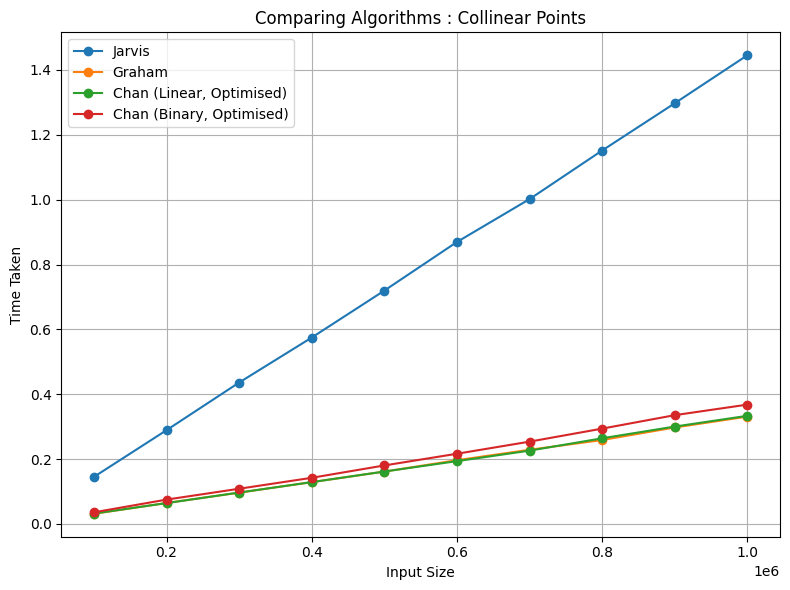

In [194]:
test.compareAllCollinear([i for i in range(100000, 1100000, 100000)], 3)